In [19]:
# common library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import DBSCAN

# xgboost related library
import xgboost as xgb

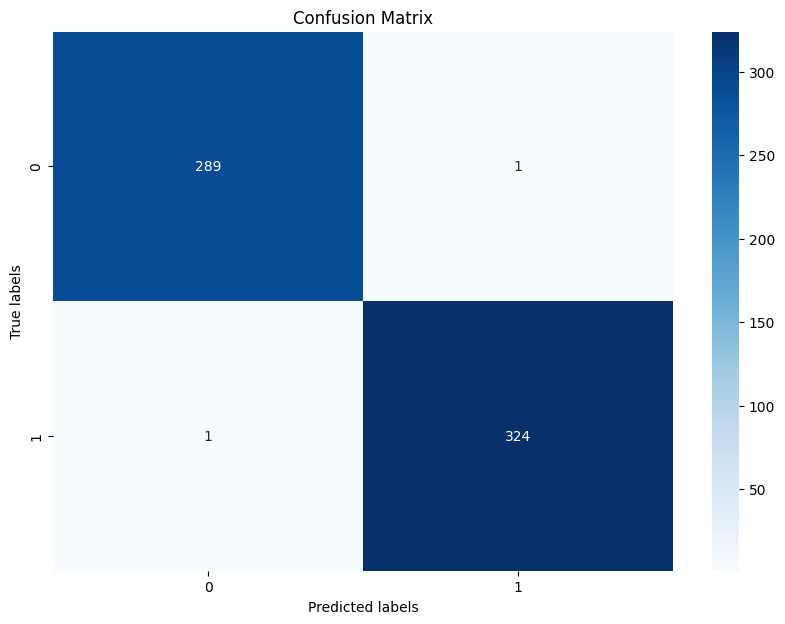

<Figure size 1200x800 with 0 Axes>

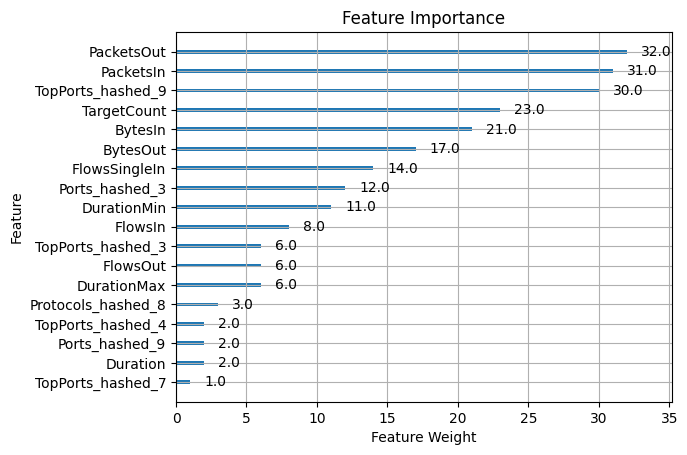

Cross-validation scores: [1.         0.99796748 1.         0.99593496 0.99796334]
Mean cross-validation score: 0.998373155829318
Test set score: 0.9967479674796748
Confusion Matrix:
[[289   1]
 [  1 324]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       325

    accuracy                           1.00       615
   macro avg       1.00      1.00      1.00       615
weighted avg       1.00      1.00      1.00       615



In [24]:
# Load data
df = pd.read_csv('preprocessed_data.csv')

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)

# Add DBSCAN labels to the DataFrame
df['dbscan_cluster'] = dbscan_labels

X = df.drop(['label', 'Attempts'], axis=1)
#X = df.drop(['label', 'Attempts', 'PacketsIn', 'BytesIn', 'PacketsOut', 'BytesOut'], axis=1)
y = df['label']

# Split data into train and test sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost model
model = xgb.XGBClassifier()

# Perform 5-fold cross-validation on the training data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Train the model on the full training data using the best parameters
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = model.score(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=20, title='Feature Importance', xlabel='Feature Weight', ylabel='Feature')
plt.show()

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")
print(f"Test set score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)